# Cisco - Ariel University API Security Detection Challenge 2023
## Baseline code


### Imports and global settings

In [36]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 4 # Options are [1, 2, 3, 4]
test_type = 'attack_type' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.Attack_Tag,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests
0,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,de-CH,none,same-origin,no-store,?1,document,['ttauth=AnmLHb1kdzYvpficmoZ6ahuxln7RK43GPlS6Q...,"Sun, 18 Dec 2022 01:42:25 GMT",GET,http://127.0.0.1:5000/orders/get/random/2,,200 OK,application/json,8,200,"[{}, {}]",NaN,NaN,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['cid=9ML55TwNFFw14MA2N-N6B8v_LTjMEyppvz3F-H99...,"Sun, 18 Dec 2022 01:44:11 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br${jndi:ldaphabbologinbr.rel7....",*/*,keep-alive,NaN,?1,"en-US,en;q=0.9,he;q=0.8",none,same-origin,no-store,?1,document,['ttauth=XSgpzlTZBc47Xm36ObpZplFzV2KbUgC68xBcA...,"Sun, 18 Dec 2022 01:34:30 GMT",GET,http://127.0.0.1:5000/login/user?username=Rich...,,401 UNAUTHORIZED,application/json,26,401,"{""error"": ""Access denied""}",LOG4J,NaN,NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10; ...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,"""Windows""",?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['ttauth=kOqLuuI_RaiyuKw-926q36BZ4s3ZH251NQ37i...,"Sun, 18 Dec 2022 01:43:59 GMT",GET,http://127.0.0.1:5000/greet/Warren,,200 OK,text/html; charset=utf-8,22,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?1,de-CH,none,websocket,max-age=0,?1,document,['ttauth=rN-ka7ksV-2K6QtY-_wNmdI1i4zY2kVoDQW6e...,"Sun, 18 Dec 2022 01:23:50 GMT",GET,http://127.0.0.1:5000/states/Bagdon?resource=R...,,404 NOT FOUND,application/json,28,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [37]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'
#add new feature
def addfeature_url(df):
    url=[]
    for i in df["request.url"]:
        if "SELECT%20" in i or "select%20" in i:
            url.append("SQL")
        elif "OR%20" in i or "or%20" in i:
            url.append("SQL")
        elif "/../" in i:
            url.append("Directory Traversal")
        elif ".__" in i:
            url.append("RCE")
        elif "import" in i:
            url.append("RCE")
        elif "script" in i:
            url.append("RCE")
        elif "%20" in i:
            url.append("Log Forging")
        elif "forum" in i:
            url.append("XSS")
        elif "cookielogin" in i:
            url.append("Cookie Injection")
        else:
            url.append("None")
    df['url'] = url
    
#add new feature
def addfeature_Cookie(df):
    mal_co=[]
    for i in df["request.headers.Set-Cookie"]:
        if(type(i)==float):
            mal_co.append("None")
        elif "${" in i:
            mal_co.append("mal")
        else:
            mal_co.append("None")
    df['mal_co'] = mal_co
    
def addfeature_Sec_Fetch_Site(df):    
    mal_Sec=[]
    for i in df["request.headers.Sec-Fetch-Site"]:
        if(type(i)==float):
            mal_Sec.append("None")
        elif "${" in i:
            mal_Sec.append("mal")
        else:
            mal_Sec.append("None")
    df['mal_set'] = mal_Sec
    
def addfeature_Encoding(df):    
    mal_Encoding=[]
    for i in df["request.headers.Accept-Encoding"]:
        if(type(i)==float):
            mal_Encoding.append("None")
        elif "${" in i:
            mal_Encoding.append("mal")
        else:
            mal_Encoding.append("None")        
    df['mal_Encoding'] = mal_Encoding
    
def addfeature_Sec_Fetch_Mode(df): 
    Fetch_Mode=[]
    for i in df["request.headers.Sec-Fetch-Mode"]:
        if(type(i)==float):
            Fetch_Mode.append("None")
        elif "${" in i:
            Fetch_Mode.append("mal")
        else:
            Fetch_Mode.append("None")
    df['Fetch_Mode'] = Fetch_Mode
    
def addfeature_Sec_Fetch_Dest(df): 
    Fetch_Dest=[]
    for i in df["request.headers.Sec-Fetch-Dest"]:
        if(type(i)==float):
            Fetch_Dest.append("None")
        elif "${" in i:
            Fetch_Dest.append("mal")
        else:
            Fetch_Dest.append("None")
    df['Fetch_Dest'] = Fetch_Dest


# After finishing the arrangements we delete the irrelevant column
df['label'] = df.apply(lambda row: categorize(row), axis=1)
addfeature_url(df)
addfeature_Cookie(df)
addfeature_Sec_Fetch_Site(df)
addfeature_Encoding(df)
addfeature_Sec_Fetch_Mode(df)
addfeature_Sec_Fetch_Dest(df)
df.drop('request.Attack_Tag', axis=1, inplace=True)
df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label,url,mal_co,mal_set,mal_Encoding,Fetch_Mode,Fetch_Dest
0,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,de-CH,none,same-origin,no-store,?1,document,['ttauth=AnmLHb1kdzYvpficmoZ6ahuxln7RK43GPlS6Q...,"Sun, 18 Dec 2022 01:42:25 GMT",GET,http://127.0.0.1:5000/orders/get/random/2,,200 OK,application/json,8,200,"[{}, {}]",NaN,NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['cid=9ML55TwNFFw14MA2N-N6B8v_LTjMEyppvz3F-H99...,"Sun, 18 Dec 2022 01:44:11 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br${jndi:ldaphabbologinbr.rel7....",*/*,keep-alive,NaN,?1,"en-US,en;q=0.9,he;q=0.8",none,same-origin,no-store,?1,document,['ttauth=XSgpzlTZBc47Xm36ObpZplFzV2KbUgC68xBcA...,"Sun, 18 Dec 2022 01:34:30 GMT",GET,http://127.0.0.1:5000/login/user?username=Rich...,,401 UNAUTHORIZED,application/json,26,401,"{""error"": ""Access denied""}",NaN,NaN,NaN,NaN,NaN,LOG4J,Malware,None,None,None,mal,None,None
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10; ...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,"""Windows""",?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['ttauth=kOqLuuI_RaiyuKw-926q36BZ4s3ZH251NQ37i...,"Sun, 18 Dec 2022 01:43:59 GMT",GET,http://127.0.0.1:5000/greet/Warren,,200 OK,text/html; charset=utf-8,22,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?1,de-CH,none,websocket,max-age=0,?1,document,['ttauth=rN-ka7ksV-2K6QtY-_wNmdI1i4zY2kVoDQW6e...,"Sun, 18 Dec 2022 01:23:50 GMT",GET,http://127.0.0.1:5000/states/Bagdon?resource=R...,,404 NOT FOUND,application/json,28,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,NaN,Benign,Benign,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182762,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,NaN,?0,"en-US,en;q=0.5",none,websocket,no-cache,?1,document,['ttauth=NPpRHbzfv7BJ5RGB9-oJNl30Ttdc8RYxbuiSe...,"Sun, 18 Dec 2022 01:25:40 GMT",GET,http://127.0.0.1:5000/login/user?username=Brue...,,401 UNAUTHORIZED,application/json,26,401,"{""error"": ""Access denied""}",NaN,NaN,NaN,NaN,NaN,SQL Injection,Malware,SQL,None,None,None,None,None
182763,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko...,"gzip, deflate, br",*/*,keep-alive,NaN,?0,de-CH,none,websocket,no-cache,?1,document,['ttauth=Mqfe3PeeakWRmzjsA7MKaNiXmVcbMxMuNQxej...,"Sun, 18 Dec 2022 01:19:48 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,104,200,text/html; charset=utf-8,NaN,username=gASVyAAAAAAAAACMCGJ1aWx0

In [38]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    print(column)
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')

    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

# df

request.headers.Sec-Ch-Ua-Platform
request.headers.Sec-Ch-Ua-Mobile
request.headers.Accept-Language
request.headers.Sec-Fetch-Site
request.headers.Sec-Fetch-Mode
request.headers.Cache-Control
request.headers.Sec-Fetch-User
request.headers.Sec-Fetch-Dest
request.headers.Set-Cookie
request.headers.Date
response.headers.Location
request.headers.Cookie
request.headers.Content-Length
response.headers.Set-Cookie
request.headers.Upgrade-Insecure-Requests


In [39]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
# settings that you use for count vectorizer will go here 
SIMPLE_HEADERS = [
                'request.headers.Accept-Language',
                'response.status',
                'url',
                'mal_co',
                'mal_set',
                'mal_Encoding',
                'Fetch_Mode',
                'request.headers.Sec-Ch-Ua-Mobile',
                'request.headers.Cache-Control',
                'request.headers.Upgrade-Insecure-Requests',
                'Fetch_Dest'
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = [ 
                    
                    'response.body',
                    'request.headers.Content-Length',
                    'request.headers.Cookie',
                    'response.headers.Set-Cookie'
                  ]

COLUMNS_TO_REMOVE = ['request.body',
                     'response.headers.Content-Type',
                     'request.headers.User-Agent',
                     'request.method',
                     'request.headers.Sec-Ch-Ua-Platform',
                     'request.url',
                    'request.headers.Set-Cookie',
                    'request.headers.Accept-Encoding',
                    'request.headers.Sec-Fetch-Site',
                     'request.headers.Sec-Fetch-Mode',
                     'request.headers.Sec-Fetch-Dest',
                     'response.headers.Location',
                     'request.headers.Host',
                     'request.headers.Accept',
                     'request.headers.Sec-Fetch-User',
                     'request.headers.Connection',
                     'response.headers.Content-Length',
                     'request.headers.Date']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    #encode to 0 or 1
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)
# just send in all your docs here 
# On these headers we will run a "simple" BOW
    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()
    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)

df



,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Cache-Control,response.status,response.status_code,response.body,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label,url,mal_co,mal_set,mal_Encoding,Fetch_Mode,Fetch_Dest
0,0,2,3,0,200,0.000000,-1.0,-1.0,-1.0,1,Benign,Benign,3,0,0,0,0,0
1,0,4,2,5,404,0.000000,-1.0,-1.0,-1.0,1,Benign,Benign,3,0,0,0,0,0
2,1,4,3,4,401,-0.577350,-1.0,-1.0,-1.0,1,LOG4J,Malware,3,0,0,1,0,0
3,1,4,2,0,200,-1.000000,-1.0,-1.0,-1.0,1,Benign,Benign,3,0,0,0,0,0
4,1,2,1,5,404,0.408248,-1.0,-1.0,-1.0,1,Benign,Benign,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182762,0,3,2,4,401,-0.577350,-1.0,-1.0,-1.0,1,SQL Injection,Malware,5,0,0,0,0,0
182763,0,2,2,0,200,-1.000000,0.0,-1.0,-1.0,1,Cookie Injection,Malware,0,0,0,0,0,0
182764,0,2,1,0,200,-1.000000,-1.0,-1.0,-1.0,1,XSS,Malware,6,0,0,0,0,0
182765,0,3,3,5,404,0.447214,-1.0,-1.0,-1.0,1,Benign,Benign,3,0,0,0,0,0


In [40]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182767 entries, 0 to 182766
Data columns (total 18 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   request.headers.Sec-Ch-Ua-Mobile           182767 non-null  int32  
 1   request.headers.Accept-Language            182767 non-null  int32  
 2   request.headers.Cache-Control              182767 non-null  int32  
 3   response.status                            182767 non-null  int32  
 4   response.status_code                       182767 non-null  int64  
 5   response.body                              182767 non-null  float64
 6   request.headers.Cookie                     182767 non-null  float64
 7   request.headers.Content-Length             182767 non-null  float64
 8   response.headers.Set-Cookie                182767 non-null  float64
 9   request.headers.Upgrade-Insecure-Requests  182767 non-null  int32  
 10  attack_t

In [41]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.Sec-Ch-Ua-Mobile', 'request.headers.Accept-Language', 'request.headers.Cache-Control', 'response.status', 'response.status_code', 'response.body', 'request.headers.Cookie', 'request.headers.Content-Length', 'response.headers.Set-Cookie', 'request.headers.Upgrade-Insecure-Requests', 'url', 'mal_co', 'mal_set', 'mal_Encoding', 'Fetch_Mode', 'Fetch_Dest']


request.headers.Sec-Ch-Ua-Mobile               int32
request.headers.Accept-Language                int32
request.headers.Cache-Control                  int32
response.status                                int32
response.status_code                           int64
response.body                                float64
request.headers.Cookie                       float64
request.headers.Content-Length               float64
response.headers.Set-Cookie                  float64
request.headers.Upgrade-Insecure-Requests      int32
attack_type                                   object
label                                         object
url                                            int32
mal_co                                         int32
mal_set                                        int32
mal_Encoding                                   int32
Fetch_Mode                                     int32
Fetch_Dest                                     int32
dtype: object

## Train test split

In [42]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(150508, 16) (150508,)
(32259, 16) (32259,)


Counter({'Benign': 143297,
         'LOG4J': 3756,
         'XSS': 8062,
         'Cookie Injection': 7725,
         'SQL Injection': 7919,
         'RCE': 3957,
         'Directory Traversal': 3985,
         'Log Forging': 4066})

## Model choosing and fitting

In [43]:
from sklearn.neighbors import NearestCentroid
from sklearn import tree
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=40)
clf.fit(X_train, y_train)
print(sorted(Counter(y_train).items()))

[('Benign', 118005), ('Cookie Injection', 6361), ('Directory Traversal', 3282), ('LOG4J', 3093), ('Log Forging', 3348), ('RCE', 3259), ('SQL Injection', 6521), ('XSS', 6639)]


## Result printout

                     precision    recall  f1-score   support

             Benign    1.00000   1.00000   1.00000     25292
   Cookie Injection    1.00000   1.00000   1.00000      1364
Directory Traversal    1.00000   1.00000   1.00000       703
              LOG4J    1.00000   1.00000   1.00000       663
        Log Forging    1.00000   1.00000   1.00000       718
                RCE    1.00000   1.00000   1.00000       698
      SQL Injection    1.00000   1.00000   1.00000      1398
                XSS    1.00000   1.00000   1.00000      1423

           accuracy                        1.00000     32259
          macro avg    1.00000   1.00000   1.00000     32259
       weighted avg    1.00000   1.00000   1.00000     32259



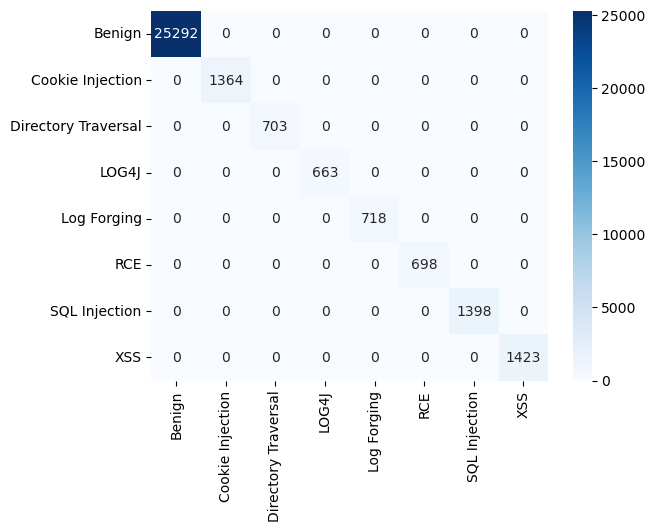

In [44]:
import statistics
# We print our results
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

# Test

In [45]:
# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)
# This loop iterates over all of the column names which are all NaN
for column in test_df.columns[test_df.isna().any()].tolist():
    print(column)
    # df.drop(column, axis=1, inplace=True)
    test_df[column] = test_df[column].fillna('None')
addfeature_url(test_df)
addfeature_Cookie(test_df)
addfeature_Sec_Fetch_Site(test_df)
addfeature_Encoding(test_df)
addfeature_Sec_Fetch_Mode(test_df)
addfeature_Sec_Fetch_Dest(test_df)
# Preprocess the validation dataset, remember that here you don't have the labels
test_df = vectorize_df(test_df)

# Predict with your model
X = test_df[features_list].to_numpy()
#predictions = predictions_M(X,clf,treeMachine,neigh)
predictions = clf.predict(X)

request.headers.Sec-Ch-Ua-Mobile
request.headers.Accept-Language
request.headers.Sec-Fetch-Site
request.headers.Sec-Fetch-Mode
request.headers.Cache-Control
request.headers.Sec-Fetch-User
request.headers.Sec-Fetch-Dest
request.headers.Set-Cookie
request.headers.Date
request.headers.Sec-Ch-Ua-Platform
request.headers.Content-Length
response.headers.Location
request.headers.Cookie
response.headers.Set-Cookie
request.headers.Upgrade-Insecure-Requests


# Save your predictions

In [46]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')
